In [70]:
### HALO index clustering - python-only pipeline



In [85]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Mythical code button"></form>''')

In [72]:
import scipy
import netCDF4 as nc
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import cmocean as cm

from importlib import reload

import sys
sys.path.append('./extraction_scripts')
import map_fxn as mf

import pipvis as vp
reload(vp)


<module 'pipvis' from '/data/tjarniko/MEOPAR/analysis_tereza/notebooks/RIVER_PAPER/carbon_clustering/pipvis.py'>

## masking edges

In [73]:
bath = '/results/nowcast-sys/NEMO-forcing/grid/mesh_mask_SalishSea2.nc'
grid = mf.import_bathy(bath)
fmask = (grid.fmask[0,0,:,:]) 

stn_x, stn_y = mf.make_stns(10)
d_stn_x, d_stn_y = mf.filter_stn_in_domain(stn_x,stn_y,fmask)

d_stn_xar = np.array(d_stn_x)
d_stn_yar = np.array(d_stn_y)

edge = np.where((d_stn_xar<=10) | (d_stn_yar>=888))
np.squeeze(edge)
np.shape(edge)
edgear = np.array(edge)
edgear = edgear[0]

d_stn_xar =np.delete(d_stn_xar,edge)
d_stn_yar = np.delete(d_stn_yar,edge)

print(np.size(d_stn_xar))


571



#### agglomerate signals extracted and save as .pkl, for year in 2013-2016

In [74]:

basedir = '/data/tjarniko/MEOPAR/analysis_tereza/notebooks/RIVER_PAPER/carbon_clustering/ncs/'

tname = './pkls/BR3_surf_oma_datamat.pkl'
signalmat = np.zeros([np.size(d_stn_xar),365])
count = 0 
for i in range(0,580):

    if i not in edgear:

        pattern = f'BR3_{i}asat_surf_sp10.nc'
        tdat = nc.Dataset(basedir+pattern)
        #print(tdat)
        signalmat[count,:] = tdat['arag_0m'][:]
        count = count+1

pickle.dump(signalmat, open(tname, 'wb'))


## open the resulting signalmats, cluster from 2-N (N=100) clusters, save linkage matrix and cluster matrices, visualise dendrograms

In [75]:

signalmat = pickle.load(open('./pkls/BR3_surf_oma_datamat.pkl', 'rb'))

Z = linkage(signalmat, 'ward')
pickle.dump(Z, open('./pkls/BR3_surf_oma_linkmat.pkl', 'wb'))

clustermat = np.zeros([100,np.size(d_stn_xar)])                           
for k in range(0,100): 
    clustermat[k,:] = fcluster(Z, k+1, criterion='maxclust')
pickle.dump(clustermat, open('./pkls/BR3_surf_oma_clustmat.pkl', 'wb'))

Text(0, 0.5, 'distance')

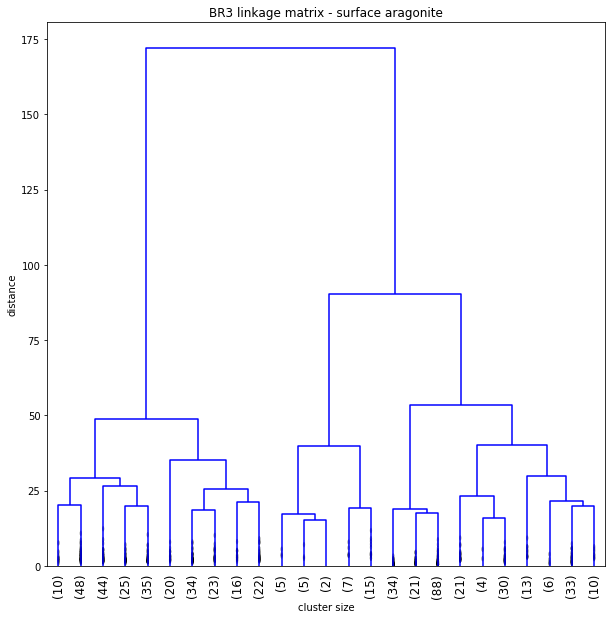

In [76]:
fact = 1
ms = 4
markersize = 10
legfontsize = 8

fig = plt.figure(figsize=(10*fact, 10*fact))

#####halo
ax1 = plt.subplot2grid((1,1),(0,0))
Z = pickle.load(open('./pkls/BR3_surf_oma_linkmat.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('BR3 linkage matrix - surface aragonite'); plt.xlabel('cluster size'); plt.ylabel('distance')



#### 'objective' measures of clustering are sometimes hard to defend

##### one way to circumvent this obvious problem is to look manually at the visual clusters provided


In [77]:
def clusters(ax1,pklnam,no_clusters, markersize = 20, legfontsize = 12 ):

    colors = ['deepskyblue','red','goldenrod','forestgreen',
    'midnightblue','orchid','gray','peru',
    'olive','sandybrown','teal','pink','tan',
    'yellow','thistle']
    
    import pickle
    import numpy as np
    import cmocean as cm
    import sys
    sys.path.append('./extraction_scripts')
    import map_fxn as mf
    from salishsea_tools import (
    viz_tools)
    
    bath = '/results/nowcast-sys/NEMO-forcing/grid/mesh_mask_SalishSea2.nc'
    grid = mf.import_bathy(bath)
    tpkl = pklnam
    cl = pickle.load(open(tpkl, 'rb'))
    
    
    cl_this = cl[no_clusters-1,:]
    np.shape(cl_this)
    viz_tools.set_aspect(ax1)   
    fmask = (grid.fmask[0,0,:,:])    
    mesh = ax1.pcolormesh(fmask, vmin=0, vmax=1, cmap = cm.cm.deep)

    ax1.set_ylim([0,898])
    ax1.set_xlim([0,398])

    stn_x, stn_y = mf.make_stns(10)
    d_stn_x, d_stn_y = mf.filter_stn_in_domain(stn_x,stn_y,fmask)

    d_stn_xar = np.array(d_stn_x)
    d_stn_yar = np.array(d_stn_y)

    edge = np.where((d_stn_xar<=10) | (d_stn_yar>=888))
    np.squeeze(edge)
    np.shape(edge)
    edgear = np.array(edge)
    edgear = edgear[0]

    d_stn_xar =np.delete(d_stn_xar,edge)
    d_stn_yar = np.delete(d_stn_yar,edge)

    #print(np.size(d_stn_xar))

    ###sort clusters by size
    cluster_ids = np.arange(1,no_clusters+1,1)
    cluster_sizes = np.zeros_like(cluster_ids)
    
    #retrieve cluster sizes
    for j in range(1,no_clusters+1):
        cluster = np.where(cl_this == j)
        cluster = np.squeeze(cluster)
        cluster_sizes[j-1] = (np.size(cluster))
    
   #sort cluster size matrix biggest to smallest
    cs = np.argsort(-cluster_sizes)
    #print(cs)

    #use those sizes to sort the cluster id list to corresponde to a list 'clust id, largest to smallest'
    new_cidlist = np.zeros_like(cluster_ids)
    for j in range(0,len(new_cidlist)):
        new_cidlist[j] = cluster_ids[cs[j]]

    #start plotting, plotting biggest cluster first, to keep colour order the same
    for j in range(0,np.size(new_cidlist)):

        cluster = np.where(cl_this == new_cidlist[j])
        cluster = np.squeeze(cluster)
        
        
        c1_x = np.take(d_stn_xar,cluster)
        c1_y = np.take(d_stn_yar,cluster)
        pts = ax1.scatter(c1_x,c1_y,s=markersize,c=colors[j], label=str(new_cidlist[j]), marker='o')
        ax1.set_xticklabels( () ) 
        ax1.set_yticklabels( () ) 
    
    tit = 'n. clusters = '+ str(no_clusters)
    ax1.legend(bbox_to_anchor=(1.1, 1), fontsize = legfontsize)
    ax1.set_title(tit,fontsize = legfontsize + 2)

## 2013

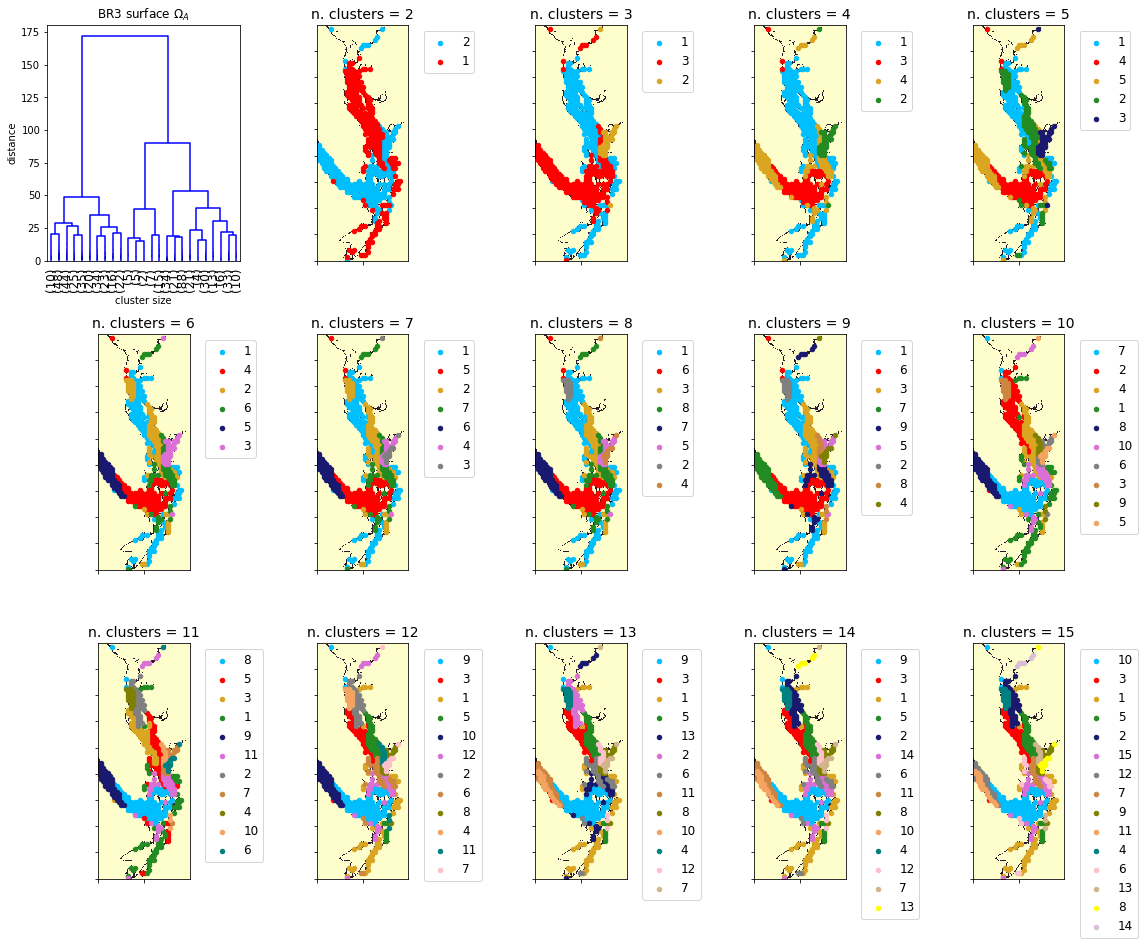

In [78]:
reload(vp)

fact = 0.9

#fig = plt.figure(figsize=(15*fact, 15*fact))
fig, axs = plt.subplots(3,5,figsize=(18*fact,15*fact))

plt.subplot(3,5,1)
Z = pickle.load(open('./pkls/BR3_surf_oma_linkmat.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('BR3 surface $\Omega_A$'); plt.xlabel('cluster size'); plt.ylabel('distance')


clusters(axs[0,1],'./pkls/BR3_surf_oma_clustmat.pkl',2)
clusters(axs[0,2],'./pkls/BR3_surf_oma_clustmat.pkl',3)
clusters(axs[0,3],'./pkls/BR3_surf_oma_clustmat.pkl',4)
clusters(axs[0,4],'./pkls/BR3_surf_oma_clustmat.pkl',5)

clusters(axs[1,0],'./pkls/BR3_surf_oma_clustmat.pkl',6)
clusters(axs[1,1],'./pkls/BR3_surf_oma_clustmat.pkl',7)
clusters(axs[1,2],'./pkls/BR3_surf_oma_clustmat.pkl',8)
clusters(axs[1,3],'./pkls/BR3_surf_oma_clustmat.pkl',9)
clusters(axs[1,4],'./pkls/BR3_surf_oma_clustmat.pkl',10)

clusters(axs[2,0],'./pkls/BR3_surf_oma_clustmat.pkl',11)
clusters(axs[2,1],'./pkls/BR3_surf_oma_clustmat.pkl',12)
clusters(axs[2,2],'./pkls/BR3_surf_oma_clustmat.pkl',13)
clusters(axs[2,3],'./pkls/BR3_surf_oma_clustmat.pkl',14)
clusters(axs[2,4],'./pkls/BR3_surf_oma_clustmat.pkl',15)

plt.tight_layout()



Text(0.5, 0.98, 'Surface $\\Omega_A$ signals, run BR3')

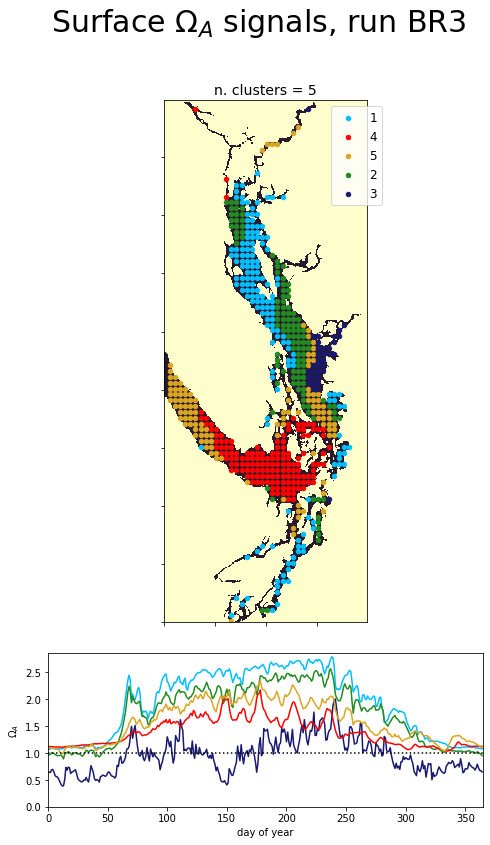

In [79]:
tclmat = pickle.load(open('./pkls/BR3_surf_oma_clustmat.pkl', 'rb'))
sig_BR3 = pickle.load(open('./pkls/BR3_surf_oma_datamat.pkl', 'rb'))

#tclmat = cl_BR3
clustno = 5

colors = ['deepskyblue','red','goldenrod','forestgreen',
    'midnightblue','orchid','gray','peru',
    'olive','sandybrown','teal','pink','tan',
    'yellow','thistle']

fact = 1.3
fig = plt.figure(figsize=(6*fact, 10*fact))
ax = plt.subplot2grid((4,1), (0,0), colspan=1, rowspan=3)


#blues
clusters(ax,'./pkls/BR3_surf_oma_clustmat.pkl',5)

ax = plt.subplot2grid((4,1), (3,0), colspan=1, rowspan=1)

#manually assign colours to match clusters
colors = ['deepskyblue','forestgreen','midnightblue','red','goldenrod']
tcl = 1; tmean = vp.cluster_patterns_mean(sig_BR3,tclmat[clustno-1,:],tcl,365)
ax.plot(np.arange(0,365,1),np.squeeze(tmean), color = colors[tcl-1])
tcl = 2; tmean = vp.cluster_patterns_mean(sig_BR3,tclmat[clustno-1,:],tcl,365)
ax.plot(np.arange(0,365,1),np.squeeze(tmean), color = colors[tcl-1])
tcl = 3; tmean = vp.cluster_patterns_mean(sig_BR3,tclmat[clustno-1,:],tcl,365)
ax.plot(np.arange(0,365,1),np.squeeze(tmean), color = colors[tcl-1])
tcl = 4; tmean = vp.cluster_patterns_mean(sig_BR3,tclmat[clustno-1,:],tcl,365)
ax.plot(np.arange(0,365,1),np.squeeze(tmean), color = colors[tcl-1])
tcl = 5; tmean = vp.cluster_patterns_mean(sig_BR3,tclmat[clustno-1,:],tcl,365)
ax.plot(np.arange(0,365,1),np.squeeze(tmean), color = colors[tcl-1])
ax.axhline(y=1,color = 'k', linestyle = ':')
ax.set_xlim([0,365])
ax.set_ylim([0,2.85])
ax.set_ylabel('$\Omega_A$')
ax.set_xlabel('day of year')

plt.suptitle('Surface $\Omega_A$ signals, run BR3', y = 0.98, fontsize = 30)

# surface pH

In [80]:
basedir = '/data/tjarniko/MEOPAR/analysis_tereza/notebooks/RIVER_PAPER/carbon_clustering/ncs/'

tname = './pkls/BR3_surf_pH_datamat.pkl'
signalmat = np.zeros([np.size(d_stn_xar),365])
count = 0 
for i in range(0,580):

    if i not in edgear:

        pattern = f'BR3_{i}pH_surf_sp10.nc'
        tdat = nc.Dataset(basedir+pattern)
        #print(tdat)
        signalmat[count,:] = tdat['pH_0m'][:]
        count = count+1

pickle.dump(signalmat, open(tname, 'wb'))


In [81]:
signalmat = pickle.load(open('./pkls/BR3_surf_pH_datamat.pkl', 'rb'))

Z = linkage(signalmat, 'ward')
pickle.dump(Z, open('./pkls/BR3_surf_pH_linkmat.pkl', 'wb'))

clustermat = np.zeros([100,np.size(d_stn_xar)])                           
for k in range(0,100): 
    clustermat[k,:] = fcluster(Z, k+1, criterion='maxclust')
pickle.dump(clustermat, open('./pkls/BR3_surf_pH_clustmat.pkl', 'wb'))

Text(0, 0.5, 'distance')

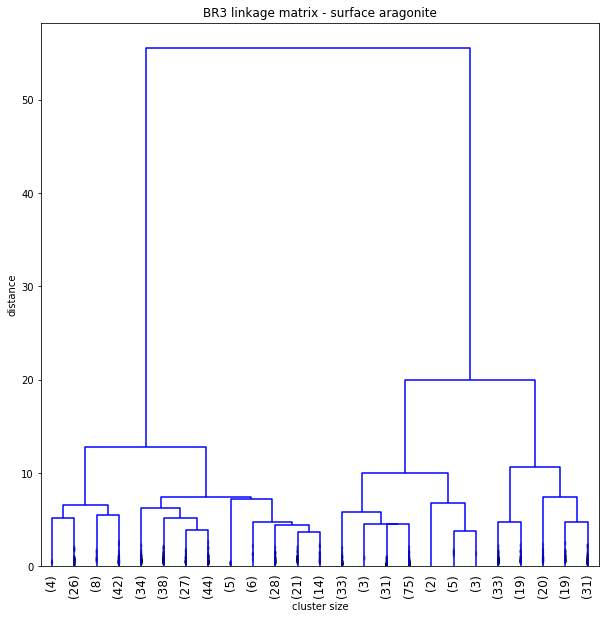

In [82]:
fact = 1
ms = 4
markersize = 10
legfontsize = 8

fig = plt.figure(figsize=(10*fact, 10*fact))

#####halo
ax1 = plt.subplot2grid((1,1),(0,0))
Z = pickle.load(open('./pkls/BR3_surf_pH_linkmat.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('BR3 linkage matrix - surface aragonite'); plt.xlabel('cluster size'); plt.ylabel('distance')



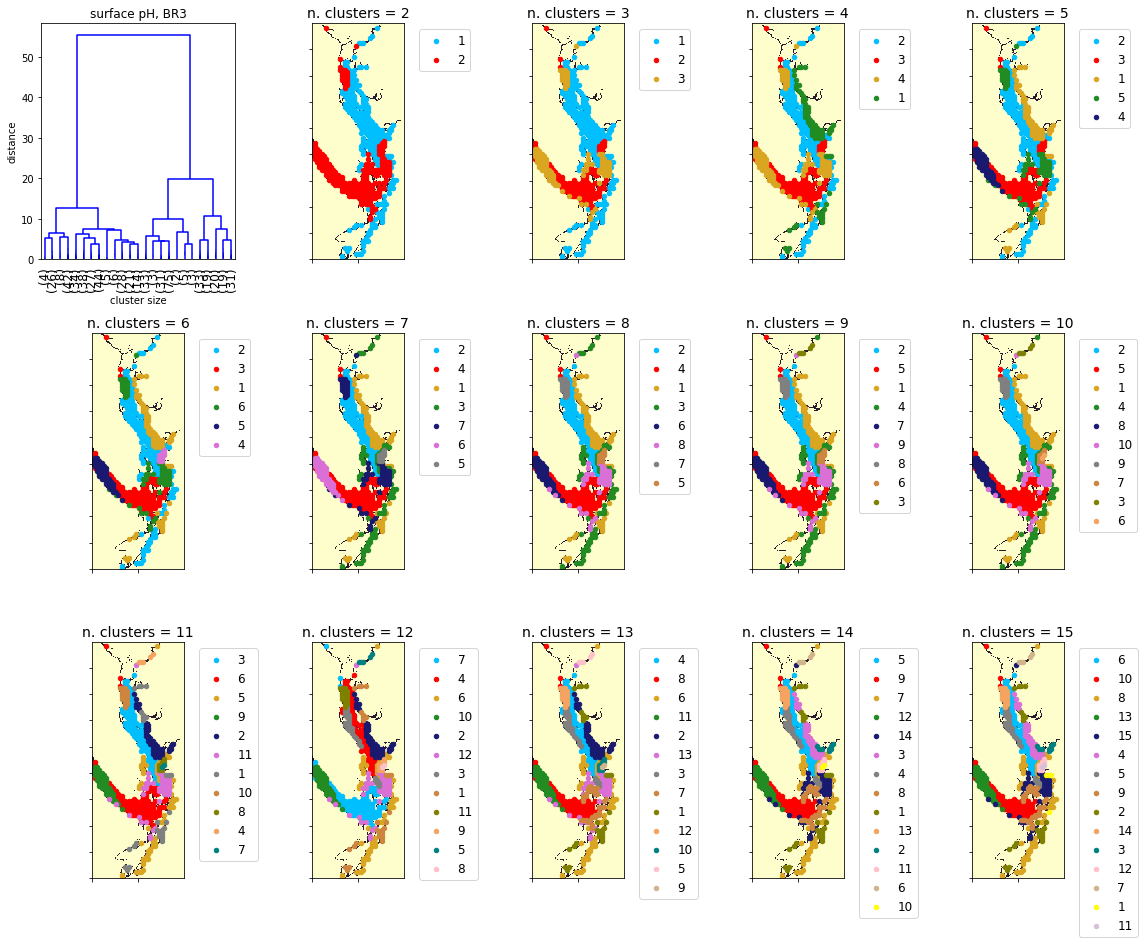

In [83]:
reload(vp)

fact = 0.9

#fig = plt.figure(figsize=(15*fact, 15*fact))
fig, axs = plt.subplots(3,5,figsize=(18*fact,15*fact))

plt.subplot(3,5,1)
Z = pickle.load(open('./pkls/BR3_surf_pH_linkmat.pkl', 'rb'))
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    color_threshold = 0,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('surface pH, BR3'); plt.xlabel('cluster size'); plt.ylabel('distance')


clusters(axs[0,1],'./pkls/BR3_surf_pH_clustmat.pkl',2)
clusters(axs[0,2],'./pkls/BR3_surf_pH_clustmat.pkl',3)
clusters(axs[0,3],'./pkls/BR3_surf_pH_clustmat.pkl',4)
clusters(axs[0,4],'./pkls/BR3_surf_pH_clustmat.pkl',5)

clusters(axs[1,0],'./pkls/BR3_surf_pH_clustmat.pkl',6)
clusters(axs[1,1],'./pkls/BR3_surf_pH_clustmat.pkl',7)
clusters(axs[1,2],'./pkls/BR3_surf_pH_clustmat.pkl',8)
clusters(axs[1,3],'./pkls/BR3_surf_pH_clustmat.pkl',9)
clusters(axs[1,4],'./pkls/BR3_surf_pH_clustmat.pkl',10)

clusters(axs[2,0],'./pkls/BR3_surf_pH_clustmat.pkl',11)
clusters(axs[2,1],'./pkls/BR3_surf_pH_clustmat.pkl',12)
clusters(axs[2,2],'./pkls/BR3_surf_pH_clustmat.pkl',13)
clusters(axs[2,3],'./pkls/BR3_surf_pH_clustmat.pkl',14)
clusters(axs[2,4],'./pkls/BR3_surf_pH_clustmat.pkl',15)

plt.tight_layout()



Text(0.5, 0.98, 'Surface pH signals, run BR3')

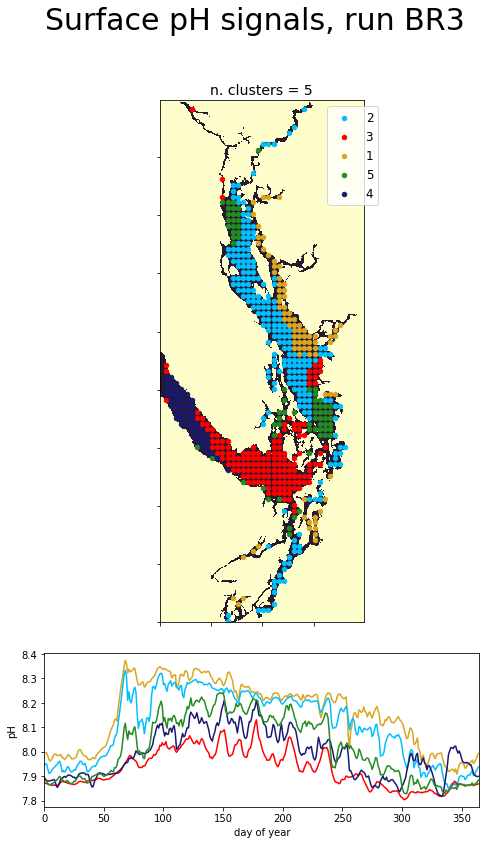

In [84]:
tclmat = pickle.load(open('./pkls/BR3_surf_pH_clustmat.pkl', 'rb'))
sig_BR3 = pickle.load(open('./pkls/BR3_surf_pH_datamat.pkl', 'rb'))

#tclmat = cl_BR3
clustno = 5

fact = 1.3
fig = plt.figure(figsize=(6*fact, 10*fact))
ax = plt.subplot2grid((4,1), (0,0), colspan=1, rowspan=3)


#blues
clusters(ax,'./pkls/BR3_surf_pH_clustmat.pkl',5)

ax = plt.subplot2grid((4,1), (3,0), colspan=1, rowspan=1)

#manually assign colours to match clusters
colors = ['goldenrod','deepskyblue','red','midnightblue','forestgreen']
tcl = 1; tmean = vp.cluster_patterns_mean(sig_BR3,tclmat[clustno-1,:],tcl,365)
ax.plot(np.arange(0,365,1),np.squeeze(tmean), color = colors[tcl-1])
tcl = 2; tmean = vp.cluster_patterns_mean(sig_BR3,tclmat[clustno-1,:],tcl,365)
ax.plot(np.arange(0,365,1),np.squeeze(tmean), color = colors[tcl-1])
tcl = 3; tmean = vp.cluster_patterns_mean(sig_BR3,tclmat[clustno-1,:],tcl,365)
ax.plot(np.arange(0,365,1),np.squeeze(tmean), color = colors[tcl-1])
tcl = 4; tmean = vp.cluster_patterns_mean(sig_BR3,tclmat[clustno-1,:],tcl,365)
ax.plot(np.arange(0,365,1),np.squeeze(tmean), color = colors[tcl-1])
tcl = 5; tmean = vp.cluster_patterns_mean(sig_BR3,tclmat[clustno-1,:],tcl,365)
ax.plot(np.arange(0,365,1),np.squeeze(tmean), color = colors[tcl-1])
#ax.axhline(y=1,color = 'k', linestyle = ':')
ax.set_xlim([0,365])
#ax.set_ylim([0,2.85])
ax.set_ylabel('pH')
ax.set_xlabel('day of year')

plt.suptitle('Surface pH signals, run BR3', y = 0.98, fontsize = 30)